In [6]:
import pandas as pd
from array import array
import ROOT as R

In [48]:
ERA = "2018"
DATASTREAM = "DoubleMuon"

# bkg alias
signals = ["MHc-70_MA-15", "MHc-70_MA-40", "MHc-70_MA-65",
           "MHc-100_MA-15", "MHc-100_MA-60", "MHc-100_MA-95",
           "MHc-130_MA-15", "MHc-130_MA-55", "MHc-130_MA-90", "MHc-130_MA-125",
           "MHc-160_MA-15", "MHc-160_MA-85", "MHc-160_MA-120", "MHc-160_MA-155"]

promptBkgs = {
    "diboson": ["WZTo3LNu_amcatnlo", "ZZTo4L_powheg"],
    "conversion": ["DYJets", "DYJets10to50_MG", "ZGToLLG"],
    "ttX": ["ttWToLNu", "ttZToLLNuNu", "ttHToNonbb"],
    "others": ["WWW", "WWZ", "WZZ", "ZZZ",
               "GluGluHToZZTo4L", "VBF_HToZZTo4L",
               "tZq", "TTG", "WWG", "TTTT", "tHq"] 
}

In [77]:
# get signal width info
def getFitSigmaValue(mA):
    with open(f"results/{ERA}/Skim3Mu__/interpolResults.csv") as f:
        line = f.readlines()[2].split(",")
    a0 = float(line[0])
    a1 = float(line[1])
    a2 = float(line[2])
    return a0 + a1*mA + a2*(mA**2)

# get file path
def getFilePath(sampleName, isPrompt=True, isSignal=False):
    promptPath = f"/home/choij/workspace/ChargedHiggsAnalysis/data/PromptUnbinned/{ERA}/Skim3Mu__DenseNet__"
    matrixPath = f"/home/choij/workspace/ChargedHiggsAnalysis/data/MatrixUnbinned/{ERA}/Skim3Mu__DenseNet__/DATA"
    
    if sampleName == DATASTREAM and isPrompt:
        return f"{promptPath}/DATA/PromptUnbinned_SkimTree_SS2lOR3l_{DATASTREAM}.root"
    elif isSignal:
        return f"{promptPath}/PromptUnbinned_TTToHcToWAToMuMu_{sampleName}.root"
    elif isPrompt:
        return f"{promptPath}/PromptUnbinned_SkimTree_SS2lOR3l_{sampleName}.root"
    elif sampleName == "nonprompt":
        return f"{matrixPath}/MatrixUnbinned_SkimTree_SS2lOR3l_{DATASTREAM}.root"
    else:
        return None

def getPairDist(sampleName, isPrompt=True, isSignal=False):
    h = R.TH2D(f"{sampleName}_2D", "", 200, 0., 200., 200, 0., 200.)
    if isSignal:
        filePath = getFilePath(sampleName, isPrompt=True, isSignal=True)
        f = R.TFile.Open(filePath); tree = f.Get("Events_Central")
        for evt in tree:
            h.Fill(evt.mass1, evt.mass2, evt.weight)
    elif isPrompt:
        sampleList = promptBkgs[sampleName]
        for sampleName in sampleList:
            filePath = getFilePath(sampleName, isPrompt=True, isSignal=False)
            f = R.TFile.Open(filePath); tree = f.Get("Events_Central")
            for evt in tree:
                h.Fill(evt.mass1, evt.mass2, evt.weight)
    else:
        filePath = getFilePath("nonprompt", isPrompt=False, isSignal=False)
        f = R.TFile.Open(filePath); tree = f.Get("Events_Central")
        for evt in tree:
            h.Fill(evt.mass1, evt.mass2, evt.weight)      
    
    h.SetDirectory(0)
    h.SetTitle(f"2D dist. for {sampleName}")
    h.GetXaxis().SetTitle("M(pair1)")
    h.GetYaxis().SetTitle("M(pair2)")
    return h

# get no. of pair events 
def getPairNumber(sampleName, mA, isPrompt=True, isSignal=False):
    h = R.TH1D("h", "", 3, 0., 3.)
    sigma = getFitSigmaValue(mA)
    if isSignal:
        filePath = getFilePath(sampleName, isPrompt=True, isSignal=True)
        f = R.TFile.Open(filePath); tree = f.Get("Events_Central")
        for evt in tree:
            binContent = 0
            if abs(evt.mass1 - mA) < 5*sigma: binContent += 1
            if abs(evt.mass2 - mA) < 5*sigma: binContent += 1
            h.Fill(binContent, evt.weight)
    elif isPrompt:
        sampleList = promptBkgs[sampleName]
        for sampleName in sampleList:
            filePath = getFilePath(sampleName, isPrompt=True, isSignal=False)
            f = R.TFile.Open(filePath); tree = f.Get("Events_Central")
            for evt in tree:
                binContent = 0
                if abs(evt.mass1 - mA) < 5*sigma: binContent += 1
                if abs(evt.mass2 - mA) < 5*sigma: binContent += 1
                h.Fill(binContent, evt.weight)
    else:   # nonprompt
        filePath = getFilePath("nonprompt", isPrompt=False, isSignal=False)
        f = R.TFile.Open(filePath); tree = f.Get("Events_Central")
        for evt in tree:
            binContent = 0
            if abs(evt.mass1 - mA) < 5*sigma: binContent += 1
            if abs(evt.mass2 - mA) < 5*sigma: binContent += 1
            h.Fill(binContent, evt.weight)
    
    return (h.GetBinContent(1), h.GetBinContent(2), h.GetBinContent(3))

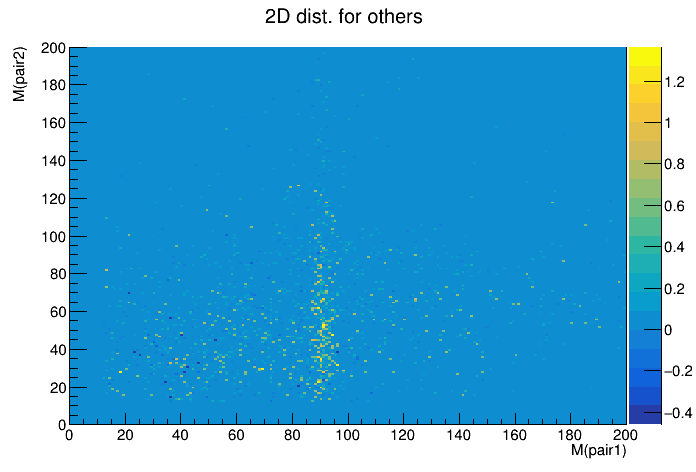

In [85]:
h = getPairDist("others", False, False)
h.SetStats(0)

c = R.TCanvas()
c.cd()
h.Draw("colz")
c.Draw()

In [65]:
for signal in signals:
    mA = int(signal.split("_")[1].split("-")[1])
    print(f"[{signal}]", getPairNumber(signal, mA, isPrompt=True, isSignal=True))
    print("[nonprompt]", getPairNumber("nonpropmt", mA, isPrompt=False, isSignal=False))
    print("[conversion]", getPairNumber("conversion", mA, isPrompt=True, isSignal=False))
    print("[diboson]", getPairNumber("diboson", mA, isPrompt=True, isSignal=False))
    print("[ttX]", getPairNumber("ttX", mA, isPrompt=True, isSignal=False))
    print("[others]", getPairNumber("others", mA, isPrompt=True, isSignal=False))
    print()

[MHc-70_MA-15] (6.969689187693019, 51.94446236056304, 0.6919407367291024)
[nonprompt] (419.1710942660377, 2.7947302456238177, 0.0)
[conversion] (31.745187316660687, 0.028946819128885526, 0.0)
[diboson] (157.91988033041065, 1.356320896831916, 0.0016069024991411554)
[ttX] (163.81691364309856, 1.025226349133934, 0.0022050234118203187)
[others] (58.4669177107793, 0.30205854422432576, 0.00010871239848326377)

[MHc-70_MA-40] (5.896896149056547, 79.86738113091265, 4.9299482925965545)
[nonprompt] (391.24277109405614, 30.65129966432345, 0.07175375328273473)
[conversion] (28.31125599808088, 3.4628781377086844, 0.0)
[diboson] (154.59831366322888, 4.657114890667908, 0.02237957584498693)
[ttX] (159.1044347411476, 5.684214591246345, 0.05569568325014249)
[others] (56.355317559978744, 2.4012436539227404, 0.012523753500616543)

[MHc-70_MA-65] (5.1332317117121, 95.87224683133063, 6.056254644573227)
[nonprompt] (365.30334157756977, 54.83109739971216, 1.8313855343817222)
[conversion] (13.75227623365754, 1